# 数据预处理

In [1]:
import pandas as pd
from glob import glob

In [2]:
#将数据变为一个字一个标签的形式

ORIGIN_DIR = './input/origin/'
data =  pd.DataFrame(columns = ['label'])

for txt_path in glob(ORIGIN_DIR + '*.txt'):
    ann_path = txt_path[:-3] + 'ann'
    content_list_key = []
    content_list_value = []
    content = ''
    with open(txt_path, 'r', encoding='utf-8') as file:
        content = file.read()

    content = content.replace('\t', ' ').replace('\n', ' ')
    #单个文本文件变为单个字符串

    for i in content:
        content_list_key.append(i)
        content_list_value.append('O')
        
    #分割成单个字符保存至列表
    #初设置所有标签为0
    
    
    index_list = []
    #用来保存ann里面的数据，包括分类，
    with open(ann_path, 'r', encoding='utf-8') as file:
        for line in file:
            index,category,text =  line.strip().split('\t')
            c_list = category.strip().split(' ')
            start = int(c_list[1])
            end = int(c_list[-1])
            index_list.append([c_list[0],start, end])
    

        for i in index_list:
            content_list_value[int(i[-2])] = 'B-' + i[0]
            for j in range(int(i[-2])+1, int(i[-1])):
                content_list_value[j] = 'I-' + i[0]
    
    dataFrame =  pd.DataFrame(data = content_list_value , columns = ['label'])
    dataFrame['text'] = content_list_key
    data = pd.concat([data,dataFrame],axis = 0)
data.head()

,label,text
0,O,中
1,O,国
2,O,成
3,O,人
4,B-Disease,2


In [3]:
column_name = 'text'
value_to_search = ' '

data = data[data[column_name] != value_to_search]

In [4]:
print(len(data['label'].value_counts().index))
print(data['label'].value_counts())


31
O               2124192
I-Test           139744
I-Disease        112270
I-Anatomy         84347
I-Test_Value      49326
I-Drug            49046
B-Test            44384
B-Disease         34308
B-Anatomy         23355
I-Reason          17237
I-Symptom         15465
B-Drug            13504
B-Test_Value       8760
I-Amount           5639
B-Symptom          4243
I-Treatment        3978
B-Reason           3746
I-Level            3197
I-Operation        2532
I-SideEff          2356
I-Duration         2155
I-Method           2013
B-Level            1534
I-Frequency        1400
B-Amount           1077
B-Treatment        1036
B-Duration          982
B-Method            871
B-SideEff           747
B-Operation         630
B-Frequency         485
Name: label, dtype: int64


In [5]:
#将原始数据变为数据
text = data['text'].tolist()
label = data['label'].tolist()

for i, v in enumerate(label):
    if v[0] == 'I' and label[i-1][0] == 'O':
        print(i)
#检测原始数据是否存在标签替换错误

values = []
index = []
interval = 75


begin=0
is_over=False
while begin!=len(text)-1 and is_over!=True:
    j=begin
    while True:
        end=j+interval
        if end>=len(text)-1:
            index.append(text[begin: -1])
            values.append(label[begin:-1])
            is_over=True
            break

        if label[end][0] !="O":
            j=j+10
            continue
        else:
            index.append(text[begin:end])
            values.append(label[begin: end])
            break
    begin=j+interval

# 将二维列表变为一维，每段合并
index_1d = [''.join(seg_chars) for seg_chars in index]     # 字符拼成句子
values_1d = [' '.join(seg_labels) for seg_labels in values] # 标签用空格拼接，保留完整 BIO 类型

final_data = pd.DataFrame({'text': index_1d, 'label': values_1d})
final_data.head()



,text,label
0,"中国成人2型糖尿病HBA1Cc控制目标的专家共识目前,2型糖尿病及其并发症已经成为危害公众健...",O O O O B-Disease I-Disease I-Disease I-Diseas...
1,"重要措施之一。虽然HBA1C。是评价血糖控制水平的公认指标,但应该控制的理想水平即目标值究竟...",O O O O O O O O O B-Test I-Test I-Test I-Test ...
2,"3)、熊本(Kumamoto,1995)、英国前瞻性糖尿病研究(UKPDS,1998)等高质...",O O O O O O O O O O O O O O O O O O O O O O O ...
3,"行严格的血糖控制会延缓糖尿病微血管病变的发生、发展,其后续研究DCCT-EDIC(2005)...",O O O O B-Test I-Test O O O O O B-Disease I-Di...
4,"管也有保护作用¨引。这些研究终点的HBA1C。控制在7.5%左右,那么年龄较大、糖尿病病程较...",O O O O O O O O O O O O O O O O O B-Test I-Tes...


In [6]:
def max_len():
    final_data["x_len"] = final_data["text"].map(lambda x: len(x))
    print(final_data["x_len"].max())
    print(final_data['x_len'].min())

In [7]:
max_len()
#bert可以接受的最大长度是500
#max_length = 400 

295
53


In [8]:
#写入csv文件
final_data = final_data.head(5000)
final_data.to_csv('./input/data.csv',encoding='utf-8-sig')

In [9]:
def get_label2id():
    data = pd.read_csv('./input/data.csv')
    # print(data.head())
    # print(data.columns)

    lines_list = []
    for line in data["label"].tolist():
        line_list = line.strip().split()
        lines_list += line_list

    lines_df = pd.Series(lines_list)
    # print(lines_df.value_counts())
    label = lines_df.value_counts().index.tolist()
    label2id = {v: k for k, v in enumerate(label)}
    return label, label2id

In [10]:
get_label2id()

(['O',
  'I-Test',
  'I-Disease',
  'I-Drug',
  'I-Test_Value',
  'I-Anatomy',
  'B-Test',
  'B-Disease',
  'I-Reason',
  'I-Symptom',
  'B-Drug',
  'B-Anatomy',
  'B-Test_Value',
  'I-Treatment',
  'B-Symptom',
  'B-Reason',
  'I-Amount',
  'I-Level',
  'I-SideEff',
  'B-Treatment',
  'I-Duration',
  'B-Level',
  'I-Method',
  'I-Operation',
  'B-SideEff',
  'B-Duration',
  'B-Method',
  'B-Amount',
  'I-Frequency',
  'B-Operation',
  'B-Frequency'],
 {'O': 0,
  'I-Test': 1,
  'I-Disease': 2,
  'I-Drug': 3,
  'I-Test_Value': 4,
  'I-Anatomy': 5,
  'B-Test': 6,
  'B-Disease': 7,
  'I-Reason': 8,
  'I-Symptom': 9,
  'B-Drug': 10,
  'B-Anatomy': 11,
  'B-Test_Value': 12,
  'I-Treatment': 13,
  'B-Symptom': 14,
  'B-Reason': 15,
  'I-Amount': 16,
  'I-Level': 17,
  'I-SideEff': 18,
  'B-Treatment': 19,
  'I-Duration': 20,
  'B-Level': 21,
  'I-Method': 22,
  'I-Operation': 23,
  'B-SideEff': 24,
  'B-Duration': 25,
  'B-Method': 26,
  'B-Amount': 27,
  'I-Frequency': 28,
  'B-Operation': 

# 划分数据集

In [11]:
def train_test_split(test_size=0.3):
    data = final_data
    num = int(len(data) * test_size)
    test_data = data[:num]
    train_data = data[num:]
    test_data.to_csv('./input/test.csv', encoding='utf-8-sig')
    train_data.to_csv('./input/train.csv',encoding='utf-8-sig')

In [12]:
train_test_split()

In [13]:
from datasets import load_dataset
from torch.utils import data

class Dataset(data.Dataset):

    def __init__(self, split="train"):
        super(Dataset, self).__init__()
        self.dataset = load_dataset(
            "csv",
            data_files="./input/" + str(split) + ".csv",
            split="train"
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        text = self.dataset[item]["text"]
        text_list=[]
        for i in range(len(text)):
            text_list.append(text[i])
        labels = self.dataset[item]["label"]
        _, label2id = get_label2id()
        labels_ = [int(label2id[i]) for i in labels.strip().split()]
#         print(text)
#         print(labels_)

        return text_list, labels_

In [14]:
import torch

# 设置全局 device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")


Using device: cuda


In [15]:
from transformers import AutoModel, AutoTokenizer
#批处理函数
def collate_fn(batch):
    sents = [i[0] for i in batch]
    labels = [i[1] for i in batch]

    tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")

    data = tokenizer.batch_encode_plus(
        sents,
        is_split_into_words = True,
        # 不添加特殊符号，不再添加 cls、sep，但是可以 pad
        # 此时的 attention_mask 在 bool 之后，正好可以输入到 crf
        # 否则添加 cls、sep 后，要对 labels、attention_mask 修改
        add_special_tokens=False,
        padding="max_length",
        max_length=245,
        return_tensors="pt",
        return_attention_mask=True,
        #max_length = 395
        # return_token_type_ids=True,
    )

    input_ids = data["input_ids"]
    attention_mask = data["attention_mask"]
    # 只有一句话，不需要 token_type_ids
    # token_type_ids = data["token_type_ids"]

    # print(input_ids)
    # print(attention_mask)
    # print(input_ids.shape)
    # exit()
    
    # 填充每个句子到最长长度，填充0
    for i in labels:
        # 列表是可变类型，不需要再定义一个 labels_
        i += ([0] * (245 - len(i)))
    labels = torch.LongTensor(labels)
    #print(labels.shape)
    #exit()

    return input_ids.to(device), attention_mask.to(device), labels.to(device)



In [16]:
#CRF
from typing import List, Optional
import torch.nn as nn


class CRF(nn.Module):
    """Conditional random field.

    This module implements a conditional random field [LMP01]_. The forward computation
    of this class computes the log likelihood of the given sequence of tags and
    emission score tensor. This class also has `~CRF.decode` method which finds
    the best tag sequence given an emission score tensor using `Viterbi algorithm`_.

    Args:
        num_tags: Number of tags.
        batch_first: Whether the first dimension corresponds to the size of a minibatch.

    Attributes:
        start_transitions (`~torch.nn.Parameter`): Start transition score tensor of size
            ``(num_tags,)``.
        end_transitions (`~torch.nn.Parameter`): End transition score tensor of size
            ``(num_tags,)``.
        transitions (`~torch.nn.Parameter`): Transition score tensor of size
            ``(num_tags, num_tags)``.


    .. [LMP01] Lafferty, J., McCallum, A., Pereira, F. (2001).
       "Conditional random fields: Probabilistic models for segmenting and
       labeling sequence data". *Proc. 18th International Conf. on Machine
       Learning*. Morgan Kaufmann. pp. 282–289.

    .. _Viterbi algorithm: https://en.wikipedia.org/wiki/Viterbi_algorithm
    """

    def __init__(self, num_tags: int, batch_first: bool = False) -> None:
        if num_tags <= 0:
            raise ValueError(f'invalid number of tags: {num_tags}')
        super().__init__()
        self.num_tags = num_tags
        self.batch_first = batch_first
        self.start_transitions = nn.Parameter(torch.empty(num_tags))
        self.end_transitions = nn.Parameter(torch.empty(num_tags))
        self.transitions = nn.Parameter(torch.empty(num_tags, num_tags))

        self.reset_parameters()

    def reset_parameters(self) -> None:
        """Initialize the transition parameters.

        The parameters will be initialized randomly from a uniform distribution
        between -0.1 and 0.1.
        """
        nn.init.uniform_(self.start_transitions, -0.1, 0.1)
        nn.init.uniform_(self.end_transitions, -0.1, 0.1)
        nn.init.uniform_(self.transitions, -0.1, 0.1)

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(num_tags={self.num_tags})'

    def forward(
            self,
            emissions: torch.Tensor,
            tags: torch.LongTensor,
            mask: Optional[torch.ByteTensor] = None,
            reduction: str = 'sum',
    ) -> torch.Tensor:
        """Compute the conditional log likelihood of a sequence of tags given emission scores.

        Args:
            emissions (`~torch.Tensor`): Emission score tensor of size
                ``(seq_length, batch_size, num_tags)`` if ``batch_first`` is ``False``,
                ``(batch_size, seq_length, num_tags)`` otherwise.
            tags (`~torch.LongTensor`): Sequence of tags tensor of size
                ``(seq_length, batch_size)`` if ``batch_first`` is ``False``,
                ``(batch_size, seq_length)`` otherwise.
            mask (`~torch.ByteTensor`): Mask tensor of size ``(seq_length, batch_size)``
                if ``batch_first`` is ``False``, ``(batch_size, seq_length)`` otherwise.
            reduction: Specifies  the reduction to apply to the output:
                ``none|sum|mean|token_mean``. ``none``: no reduction will be applied.
                ``sum``: the output will be summed over batches. ``mean``: the output will be
                averaged over batches. ``token_mean``: the output will be averaged over tokens.

        Returns:
            `~torch.Tensor`: The log likelihood. This will have size ``(batch_size,)`` if
            reduction is ``none``, ``()`` otherwise.
        """
        self._validate(emissions, tags=tags, mask=mask)
        if reduction not in ('none', 'sum', 'mean', 'token_mean'):
            raise ValueError(f'invalid reduction: {reduction}')
        if mask is None:
            mask = torch.ones_like(tags, dtype=torch.uint8)

        if self.batch_first:
            emissions = emissions.transpose(0, 1)
            tags = tags.transpose(0, 1)
            mask = mask.transpose(0, 1)

        # shape: (batch_size,)
        numerator = self._compute_score(emissions, tags, mask)
        # shape: (batch_size,)
        denominator = self._compute_normalizer(emissions, mask)
        # shape: (batch_size,)
        llh = numerator - denominator

        if reduction == 'none':
            return llh
        if reduction == 'sum':
            return llh.sum()
        if reduction == 'mean':
            return llh.mean()
        assert reduction == 'token_mean'
        return llh.sum() / mask.float().sum()

    def decode(self, emissions: torch.Tensor,
               mask: Optional[torch.ByteTensor] = None) -> List[List[int]]:
        """Find the most likely tag sequence using Viterbi algorithm.

        Args:
            emissions (`~torch.Tensor`): Emission score tensor of size
                ``(seq_length, batch_size, num_tags)`` if ``batch_first`` is ``False``,
                ``(batch_size, seq_length, num_tags)`` otherwise.
            mask (`~torch.ByteTensor`): Mask tensor of size ``(seq_length, batch_size)``
                if ``batch_first`` is ``False``, ``(batch_size, seq_length)`` otherwise.

        Returns:
            List of list containing the best tag sequence for each batch.
        """
        self._validate(emissions, mask=mask)
        if mask is None:
            mask = emissions.new_ones(emissions.shape[:2], dtype=torch.uint8)

        if self.batch_first:
            emissions = emissions.transpose(0, 1)
            mask = mask.transpose(0, 1)

        return self._viterbi_decode(emissions, mask)

    def _validate(
            self,
            emissions: torch.Tensor,
            tags: Optional[torch.LongTensor] = None,
            mask: Optional[torch.ByteTensor] = None) -> None:
        if emissions.dim() != 3:
            raise ValueError(f'emissions must have dimension of 3, got {emissions.dim()}')
        if emissions.size(2) != self.num_tags:
            raise ValueError(
                f'expected last dimension of emissions is {self.num_tags}, '
                f'got {emissions.size(2)}')

        if tags is not None:
            if emissions.shape[:2] != tags.shape:
                raise ValueError(
                    'the first two dimensions of emissions and tags must match, '
                    f'got {tuple(emissions.shape[:2])} and {tuple(tags.shape)}')

        if mask is not None:
            if emissions.shape[:2] != mask.shape:
                raise ValueError(
                    'the first two dimensions of emissions and mask must match, '
                    f'got {tuple(emissions.shape[:2])} and {tuple(mask.shape)}')
            no_empty_seq = not self.batch_first and mask[0].all()
            no_empty_seq_bf = self.batch_first and mask[:, 0].all()
            if not no_empty_seq and not no_empty_seq_bf:
                raise ValueError('mask of the first timestep must all be on')

    def _compute_score(
            self, emissions: torch.Tensor, tags: torch.LongTensor,
            mask: torch.ByteTensor) -> torch.Tensor:
        # emissions: (seq_length, batch_size, num_tags)
        # tags: (seq_length, batch_size)
        # mask: (seq_length, batch_size)
        assert emissions.dim() == 3 and tags.dim() == 2
        assert emissions.shape[:2] == tags.shape
        assert emissions.size(2) == self.num_tags
        assert mask.shape == tags.shape
        assert mask[0].all()

        seq_length, batch_size = tags.shape
        mask = mask.float()

        # Start transition score and first emission
        # shape: (batch_size,)
        score = self.start_transitions[tags[0]]
        score += emissions[0, torch.arange(batch_size), tags[0]]

        for i in range(1, seq_length):
            # Transition score to next tag, only added if next timestep is valid (mask == 1)
            # shape: (batch_size,)
            score += self.transitions[tags[i - 1], tags[i]] * mask[i]

            # Emission score for next tag, only added if next timestep is valid (mask == 1)
            # shape: (batch_size,)
            score += emissions[i, torch.arange(batch_size), tags[i]] * mask[i]

        # End transition score
        # shape: (batch_size,)
        seq_ends = mask.long().sum(dim=0) - 1
        # shape: (batch_size,)
        last_tags = tags[seq_ends, torch.arange(batch_size)]
        # shape: (batch_size,)
        score += self.end_transitions[last_tags]

        return score

    def _compute_normalizer(
            self, emissions: torch.Tensor, mask: torch.ByteTensor) -> torch.Tensor:
        # emissions: (seq_length, batch_size, num_tags)
        # mask: (seq_length, batch_size)
        assert emissions.dim() == 3 and mask.dim() == 2
        assert emissions.shape[:2] == mask.shape
        assert emissions.size(2) == self.num_tags
        assert mask[0].all()

        seq_length = emissions.size(0)

        # Start transition score and first emission; score has size of
        # (batch_size, num_tags) where for each batch, the j-th column stores
        # the score that the first timestep has tag j
        # shape: (batch_size, num_tags)
        score = self.start_transitions + emissions[0]

        for i in range(1, seq_length):
            # Broadcast score for every possible next tag
            # shape: (batch_size, num_tags, 1)
            broadcast_score = score.unsqueeze(2)

            # Broadcast emission score for every possible current tag
            # shape: (batch_size, 1, num_tags)
            broadcast_emissions = emissions[i].unsqueeze(1)

            # Compute the score tensor of size (batch_size, num_tags, num_tags) where
            # for each sample, entry at row i and column j stores the sum of scores of all
            # possible tag sequences so far that end with transitioning from tag i to tag j
            # and emitting
            # shape: (batch_size, num_tags, num_tags)
            next_score = broadcast_score + self.transitions + broadcast_emissions

            # Sum over all possible current tags, but we're in score space, so a sum
            # becomes a log-sum-exp: for each sample, entry i stores the sum of scores of
            # all possible tag sequences so far, that end in tag i
            # shape: (batch_size, num_tags)
            next_score = torch.logsumexp(next_score, dim=1)

            # Set score to the next score if this timestep is valid (mask == 1)
            # shape: (batch_size, num_tags)
            score = torch.where(mask[i].unsqueeze(1), next_score, score)

        # End transition score
        # shape: (batch_size, num_tags)
        score += self.end_transitions

        # Sum (log-sum-exp) over all possible tags
        # shape: (batch_size,)
        return torch.logsumexp(score, dim=1)

    def _viterbi_decode(self, emissions: torch.FloatTensor,
                        mask: torch.ByteTensor) -> List[List[int]]:
        # emissions: (seq_length, batch_size, num_tags)
        # mask: (seq_length, batch_size)
        assert emissions.dim() == 3 and mask.dim() == 2
        assert emissions.shape[:2] == mask.shape
        assert emissions.size(2) == self.num_tags
        assert mask[0].all()

        seq_length, batch_size = mask.shape

        # Start transition and first emission
        # shape: (batch_size, num_tags)
        score = self.start_transitions + emissions[0]
        history = []

        # score is a tensor of size (batch_size, num_tags) where for every batch,
        # value at column j stores the score of the best tag sequence so far that ends
        # with tag j
        # history saves where the best tags candidate transitioned from; this is used
        # when we trace back the best tag sequence

        # Viterbi algorithm recursive case: we compute the score of the best tag sequence
        # for every possible next tag
        for i in range(1, seq_length):
            # Broadcast viterbi score for every possible next tag
            # shape: (batch_size, num_tags, 1)
            broadcast_score = score.unsqueeze(2)

            # Broadcast emission score for every possible current tag
            # shape: (batch_size, 1, num_tags)
            broadcast_emission = emissions[i].unsqueeze(1)

            # Compute the score tensor of size (batch_size, num_tags, num_tags) where
            # for each sample, entry at row i and column j stores the score of the best
            # tag sequence so far that ends with transitioning from tag i to tag j and emitting
            # shape: (batch_size, num_tags, num_tags)
            next_score = broadcast_score + self.transitions + broadcast_emission

            # Find the maximum score over all possible current tag
            # shape: (batch_size, num_tags)
            next_score, indices = next_score.max(dim=1)

            # Set score to the next score if this timestep is valid (mask == 1)
            # and save the index that produces the next score
            # shape: (batch_size, num_tags)
            score = torch.where(mask[i].unsqueeze(1), next_score, score)
            history.append(indices)

        # End transition score
        # shape: (batch_size, num_tags)
        score += self.end_transitions

        # Now, compute the best path for each sample

        # shape: (batch_size,)
        seq_ends = mask.long().sum(dim=0) - 1
        best_tags_list = []

        for idx in range(batch_size):
            # Find the tag which maximizes the score at the last timestep; this is our best tag
            # for the last timestep
            _, best_last_tag = score[idx].max(dim=0)
            best_tags = [best_last_tag.item()]

            # We trace back where the best last tag comes from, append that to our best tag
            # sequence, and trace it back again, and so on
            for hist in reversed(history[:seq_ends[idx]]):
                best_last_tag = hist[idx][best_tags[-1]]
                best_tags.append(best_last_tag.item())

            # Reverse the order because we start from the last timestep
            best_tags.reverse()
            best_tags_list.append(best_tags)

        return best_tags_list


In [17]:
#bert + lstm + linear
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.bert = AutoModel.from_pretrained("bert-base-chinese")
        self.bert.to(device)#预处理模型
        for param in self.bert.parameters():
            param.requires_grad_(False)

        self.lstm = nn.LSTM(
            768,
            256,
            batch_first=True,
            dropout = 0.,
            bidirectional=True,
        )#下游模型初始化
        
        self.fc = nn.Linear(2 * 256, 31)
        # in_features = 2* 256, out_features = 31
        #in_features = bert的输出  
        self.crf = CRF(num_tags=31, batch_first=True)

    def _get_lstm_feature(self, input_ids, attention_mask):
        with torch.no_grad():
            out = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )
        # 这个位置不能取 out.last_hidden_state[:, 0]
        # 当直接分类时，可以这么取
        # out.last_hidden_state.shape = (batch_size, 400, 768)
        out = out.last_hidden_state
        # print(out.shape)
        # exit()
        out, _ = self.lstm(out)#隐含张量和细胞状态
        # self.fc(out).shape = (bs, 352, 31)
        return self.fc(out)

    def forward(self, input_ids, attention_mask):
        out = self._get_lstm_feature(input_ids, attention_mask)
        # 在 crf 中单独设置 mask.bool()，loss_fn 同理
        return self.crf.decode(out, attention_mask.bool())

    def loss_fn(self, input_ids, attention_mask, labels):
        pred = self._get_lstm_feature(input_ids, attention_mask)
        return -self.crf.forward(pred, labels, attention_mask.bool(), reduction="mean")

In [18]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
model = Model()
model.to(device)

Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [ ]:
# # old train function
# # treat it as a backup
# # def train():
#     dataset = Dataset("train")
#     loader = data.DataLoader(
#         dataset,
#         collate_fn=collate_fn,
#         batch_size=50,
#         shuffle=True,
#         # drop_last=False  # 默认就是 False
#     )

    
#     model = Model().to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

#     for e in range(3):
#         for b, (input_ids, attention_mask, labels) in enumerate(loader):
#             input_ids = input_ids.to(device)
#             attention_mask = attention_mask.to(device)
#             labels = labels.to(device)

#             # 需要重新设置 .train()，因为 test() 设置了 .eval()
#             model.train()

#             # 不用再设置 mask.bool()，定义 Model 已经单独设置
#             out = model(input_ids, attention_mask)
#             loss = model.loss_fn(input_ids, attention_mask, labels)
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()

#             # if b % 10 == 0:
#             labels_ = []
#             total = 0
#             correct = 0

#             for y, m in zip(labels, attention_mask):
#                 # labels_ 是去掉 pad 的 labels
#                 labels_.append(y[m == 1].tolist())
#             # print(attention_mask)
#             # print(labels)
#             # print(labels_)
#             # print(out)
#             # exit()

#             for y, pre_y in zip(labels_, out):
#                 y, pre_y = torch.tensor(y), torch.tensor(pre_y)
#                 correct += (y == pre_y).sum()
#                 total += len(y)

#             acc = correct / total

#             #test_loss, test_acc, report_dict = test(model)

#             print(
#                 " epoch: ", e,
#                 " batch: ", b,
#                 " train_loss: ", round(loss.item(), 3),
#                 " train_acc ", round(acc.item(), 3),
                
#             )

#             # if b == 50:
#             #     exit()

#         torch.save(model, 'model' +  f"model_{e}.pth")

In [20]:
# changed
import matplotlib.pyplot as plt
from seqeval.metrics import precision_score, recall_score, f1_score

# --- 小工具：计算 token-level accuracy（按 attention_mask 去掉 PAD）---
@torch.no_grad()
def batch_token_accuracy(preds, labels, attention_mask):
    """
    preds:  模型输出的预测（与你当前代码保持一致：可迭代，与 labels 按样本对齐）
    labels: [B, T]
    attention_mask: [B, T]，有效位置为 1
    返回：该 batch 的 (correct, total)
    """
    correct, total = 0, 0
    # 与你原来的逐样本 zip 逻辑一致，尽量不假设模型输出的具体 shape
    for y, m, pre_y in zip(labels, attention_mask, preds):
        y_valid = y[m == 1].tolist()
        pre_y_valid = torch.tensor(pre_y).tolist()  # 你原来是 list/ndarray，这里统一成 list
        # 对齐长度（避免极端情况下长度不一致报错）
        L = min(len(y_valid), len(pre_y_valid))
        if L == 0:
            continue
        correct += sum(int(a == b) for a, b in zip(y_valid[:L], pre_y_valid[:L]))
        total   += L
    return correct, total

def train(num_epochs=5, batch_size=50, lr=1e-3, save_path="model_epoch.pth", log_interval=10):
    # 1) DataLoader
    dataset = Dataset("train")
    loader = data.DataLoader(
        dataset,
        collate_fn=collate_fn,
        batch_size=batch_size,
        shuffle=True,
    )

    # 2) Model & Optimizer
    model = Model().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 3) History（用于画 curve）
    history = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "precision": [],
        "recall": [],
        "f1": []
    }

    # 4) 训练循环
    for e in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0

        # 用于 seqeval 的真实标签 & 预测标签
        all_true, all_pred = [], []
        _, label2id = get_label2id()
        id2label = {v: k for k, v in label2id.items()}


        for b, (input_ids, attention_mask, labels) in enumerate(loader, start=1):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            # forward
            out = model(input_ids, attention_mask)  # 你原来的 forward
            loss = model.loss_fn(input_ids, attention_mask, labels)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 累计 loss
            batch_size_now = labels.size(0)
            running_loss += loss.item() * batch_size_now

            # 计算 batch accuracy（复用你原来的逻辑）
            correct, total = batch_token_accuracy(out, labels, attention_mask)
            running_correct += correct
            running_total   += total
            
            # ====== 组装 seqeval 格式数据 ======
            # labels: [B,T], out: list of list (预测标签id序列)
            for y_true, y_pred, mask in zip(labels, out, attention_mask):
                valid_len = int(mask.sum().item())
                y_true_seq = y_true[:valid_len].cpu().tolist()
                y_pred_seq = y_pred[:valid_len]  # 已经是 list[int]

                
                all_true.append([id2label[i] for i in y_true_seq])
                all_pred.append([id2label[i] for i in y_pred_seq])


            # 可选：batch 级别日志
            if b % log_interval == 0:
                acc_now = (running_correct / running_total) if running_total > 0 else 0.0
                print(f"[epoch {e}/{num_epochs}] batch {b} "
                      f"avg_loss {running_loss / (b*batch_size):.4f}  "
                      f"avg_acc {acc_now:.4f}")

        # --- 一个 epoch 结束，写入 history ---
        epoch_loss = running_loss / len(dataset)
        epoch_acc  = (running_correct / running_total) if running_total > 0 else 0.0
        precision = precision_score(all_true, all_pred)
        recall    = recall_score(all_true, all_pred)
        f1        = f1_score(all_true, all_pred)

        history["epoch"].append(e)
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc)
        history["precision"].append(precision)
        history["recall"].append(recall)
        history["f1"].append(f1)

        print(f"[epoch {e}/{num_epochs}] "
              f"loss={epoch_loss:.4f} acc={epoch_acc:.4f} "
              f"P={precision:.4f} R={recall:.4f} F1={f1:.4f}")


    # 保存 checkpoint
    torch.save(model, save_path)

    return history  # 在函数外画图


In [23]:
import matplotlib.pyplot as plt

def plot_history(history, smooth=1):
    def moving_avg(xs, k):
        if k <= 1 or k > len(xs): return xs
        out = []
        s = 0.0
        for i, v in enumerate(xs):
            s += v
            if i >= k: s -= xs[i-k]
            out.append(s / min(i+1, k))
        return out

    epochs = history["epoch"]

    # 平滑处理
    def S(key):
        return moving_avg(history[key], smooth) if smooth > 1 else history[key]

    # Loss
    plt.figure()
    plt.plot(epochs, S("train_loss"), label="train_loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss curve"); plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(epochs, S("train_acc"), label="train_acc")
    plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Accuracy curve"); plt.legend()
    plt.show()

    # Precision / Recall / F1
    plt.figure()
    plt.plot(epochs, S("precision"), label="precision")
    plt.plot(epochs, S("recall"),    label="recall")
    plt.plot(epochs, S("f1"),        label="f1")
    plt.xlabel("epoch"); plt.ylabel("score"); plt.title("Precision / Recall / F1")
    plt.legend()
    plt.show()



[epoch 1/50] batch 10 avg_loss 117.3210  avg_acc 0.7119
[epoch 1/50] batch 20 avg_loss 94.8278  avg_acc 0.7463
[epoch 1/50] batch 30 avg_loss 86.5938  avg_acc 0.7562
[epoch 1/50] batch 40 avg_loss 80.0813  avg_acc 0.7658
[epoch 1/50] batch 50 avg_loss 75.1314  avg_acc 0.7738
[epoch 1/50] batch 60 avg_loss 71.6168  avg_acc 0.7789
[epoch 1/50] batch 70 avg_loss 68.2692  avg_acc 0.7853
[epoch 1/50] loss=68.2692 acc=0.7853 P=0.0990 R=0.0544 F1=0.0702
[epoch 2/50] batch 10 avg_loss 47.8812  avg_acc 0.8243
[epoch 2/50] batch 20 avg_loss 44.5138  avg_acc 0.8348
[epoch 2/50] batch 30 avg_loss 43.1557  avg_acc 0.8389
[epoch 2/50] batch 40 avg_loss 42.6309  avg_acc 0.8385
[epoch 2/50] batch 50 avg_loss 41.5469  avg_acc 0.8407
[epoch 2/50] batch 60 avg_loss 40.8207  avg_acc 0.8417
[epoch 2/50] batch 70 avg_loss 40.0637  avg_acc 0.8437
[epoch 2/50] loss=40.0637 acc=0.8437 P=0.2921 R=0.2595 F1=0.2748
[epoch 3/50] batch 10 avg_loss 34.7312  avg_acc 0.8559
[epoch 3/50] batch 20 avg_loss 34.4159  avg_

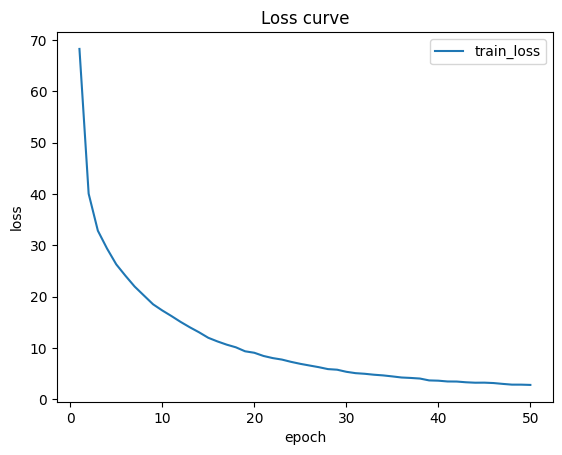

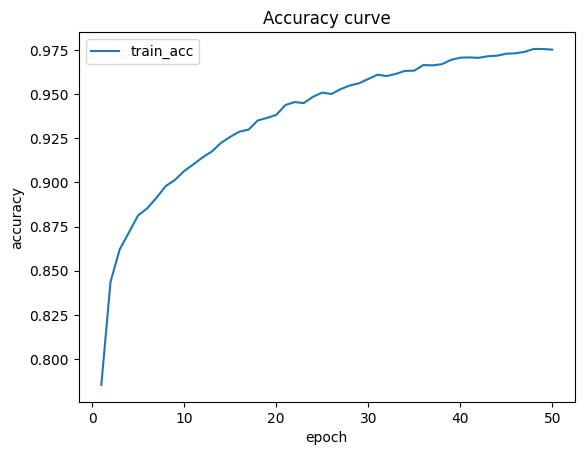

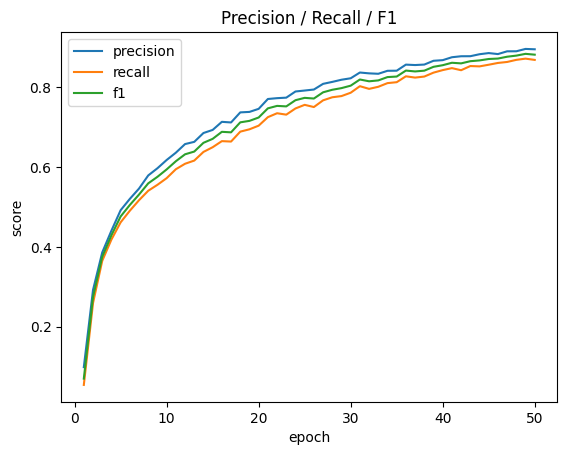

In [24]:
# 训练 & 画图
history = train(num_epochs=50, batch_size=50, lr=1e-3)
plot_history(history, smooth=1)

In [29]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

def test(model):
    # DataLoader
    dataset = Dataset("test")
    loader = data.DataLoader(dataset, batch_size=50, collate_fn=collate_fn)

    model.eval()
    _, label2id = get_label2id()  # 假设 0->"O", 1->"B", 2->"I"
    id2label = {v: k for k, v in label2id.items()}

    total_loss = 0.0
    total_tokens = 0
    correct_tokens = 0

    # 用于 seqeval（entity-level 指标）
    all_true = []   # List[List[str]]  e.g. ["B","I","O",...]
    all_pred = []   # List[List[str]]
    
    with torch.no_grad():
        for input_ids, mask, labels in loader:
            input_ids = input_ids.to(device)
            mask      = mask.to(device)
            labels    = labels.to(device)

            # forward + loss
            preds = model(input_ids, mask)                   # list[list[int]] (CRF decode)
            loss  = model.loss_fn(input_ids, mask, labels)   # NLL
            total_loss += loss.item() * input_ids.size(0)

            # 汇总 token-level acc & 组装 seqeval 的标签序列
            for y_true, y_pred, m in zip(labels, preds, mask):
                valid_len = int(m.sum().item())
                if valid_len <= 0:
                    continue
                true_ids = y_true[:valid_len].tolist()   # List[int]
                pred_ids = y_pred[:valid_len]            # List[int]

                # token-level accuracy
                correct_tokens += sum(int(a == b) for a, b in zip(true_ids, pred_ids))
                total_tokens   += valid_len

                # 转成 BIO 字符串标签供 seqeval 使用
                all_true.append([id2label[i] for i in true_ids])
                all_pred.append([id2label[i] for i in pred_ids])

    # 聚合指标
    avg_loss   = total_loss / len(dataset) if len(dataset) > 0 else 0.0
    token_acc  = correct_tokens / total_tokens if total_tokens > 0 else 0.0
    precision  = precision_score(all_true, all_pred)  # entity-level (strict)
    recall     = recall_score(all_true, all_pred)
    f1         = f1_score(all_true, all_pred)
    report_str = classification_report(all_true, all_pred)  # 字符串报告

    
    # 你可以选择返回 dict，便于写入 history 或保存
    return {
        "loss": avg_loss,
        "token_acc": token_acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "report": report_str
    }


In [30]:
model = torch.load("model_epoch.pth", map_location=device) 
test_history = test(model)

In [31]:
test_history

{'loss': 23.78817516962687,
 'token_acc': 0.8733395301673145,
 'precision': 0.5848341232227489,
 'recall': 0.5787992495309568,
 'f1': 0.5818010372465819,
 'report': '              precision    recall  f1-score   support\n\n      Amount       0.59      0.29      0.39        58\n     Anatomy       0.51      0.49      0.50       604\n     Disease       0.61      0.74      0.67      1383\n        Drug       0.77      0.64      0.70      1408\n    Duration       0.24      0.20      0.22        40\n   Frequency       1.00      0.05      0.09        21\n       Level       0.41      0.27      0.33       126\n      Method       0.36      0.12      0.18        75\n   Operation       0.64      0.12      0.20        60\n      Reason       0.25      0.23      0.24       176\n     SideEff       0.04      0.01      0.02       102\n     Symptom       0.31      0.34      0.32       313\n        Test       0.61      0.72      0.66      1540\n  Test_Value       0.45      0.36      0.40       442\n   Trea

In [ ]:
#无lstm模型
#bert + crf
class ModelWithoutLSTM(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.bert = AutoModel.from_pretrained("bert-base-chinese")
        self.bert.to(device)
        for param in self.bert.parameters():
            param.requires_grad_(False)

        
        self.fc = nn.Linear(768, 31) 
        self.crf = CRF(num_tags=31, batch_first=True)
        out = out.last_hidden_state
        return self.fc(out)

    def forward(self, input_ids, attention_mask):
        out = self.fc(out)
        # 在 crf 中单独设置 mask.bool()，loss_fn 同理
        return self.crf.decode(out, attention_mask.bool())

    def loss_fn(self, input_ids, attention_mask, labels):
        pred = self.fc(out)
        return -self.crf.forward(pred, labels, attention_mask.bool(), reduction="mean")

In [ ]:
def trainWithoutLSTM():
    dataset = Dataset("train")
    loader = data.DataLoader(
        dataset,
        collate_fn=collate_fn,
        batch_size=100,
        shuffle=True,
        # drop_last=False  # 默认就是 False
    )

    
    model = Model().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    for e in range(3):
        for b, (input_ids, attention_mask, labels) in enumerate(loader):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            # 需要重新设置 .train()，因为 test() 设置了 .eval()
            model.train()

            # 不用再设置 mask.bool()，定义 Model 已经单独设置
            out = model(input_ids, attention_mask)
            loss = model.loss_fn(input_ids, attention_mask, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # if b % 10 == 0:
            labels_ = []
            total = 0
            correct = 0

            for y, m in zip(labels, attention_mask):
                # labels_ 是去掉 pad 的 labels
                labels_.append(y[m == 1].tolist())
            # print(attention_mask)
            # print(labels)
            # print(labels_)
            # print(out)
            # exit()

            for y, pre_y in zip(labels_, out):
                y, pre_y = torch.tensor(y), torch.tensor(pre_y)
                correct += (y == pre_y).sum()
                total += len(y)

            acc = correct / total

            test_loss, test_acc, report_dict = test(model)

            print(
                " epoch: ", e,
                " batch: ", b,
                " train_loss: ", round(loss.item(), 3),
                " train_acc ", round(acc.item(), 3),
                " test_loss: ", round(test_loss, 3),
                " test_acc: ", round(test_acc, 3),
                " test_precision: ", round(report_dict["precision"], 3),
                " test_recall: ", round(report_dict["recall"], 3),
            )

            # if b == 50:
            #     exit()

        torch.save(model, 'model' +  f"model_{e}.pth")